In [4]:
import data.prem_data_collection
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupKFold, cross_val_score

                        name squad_size avg_age Foreigners  matchday  \
0                    Arsenal         40    24.6         23         1   
1                    Arsenal         40    24.6         23         2   
2                    Arsenal         40    24.6         23         3   
3                    Arsenal         40    24.6         23         4   
4                    Arsenal         40    24.6         23         5   
..                       ...        ...     ...        ...       ...   
755  Wolverhampton Wanderers         47    23.9         32        34   
756  Wolverhampton Wanderers         47    23.9         32        35   
757  Wolverhampton Wanderers         47    23.9         32        36   
758  Wolverhampton Wanderers         47    23.9         32        37   
759  Wolverhampton Wanderers         47    23.9         32        38   

     cumsum_pts  cumsum_xpts  non-penalty xGD  pressing intensity  \
0             3       1.1754        -0.123685          108.000000 

Matplotlib is building the font cache; this may take a moment.


In [5]:
importlib.reload(data.prem_data_collection)
df = data.prem_data_collection.df

                        name squad_size avg_age Foreigners  matchday  \
0                    Arsenal         40    24.6         23         1   
1                    Arsenal         40    24.6         23         2   
2                    Arsenal         40    24.6         23         3   
3                    Arsenal         40    24.6         23         4   
4                    Arsenal         40    24.6         23         5   
..                       ...        ...     ...        ...       ...   
755  Wolverhampton Wanderers         47    23.9         32        34   
756  Wolverhampton Wanderers         47    23.9         32        35   
757  Wolverhampton Wanderers         47    23.9         32        36   
758  Wolverhampton Wanderers         47    23.9         32        37   
759  Wolverhampton Wanderers         47    23.9         32        38   

     cumsum_pts  cumsum_xpts  non-penalty xGD  pressing intensity  \
0             3       1.1754        -0.123685          108.000000 

In [6]:
train_df = df[df["matchday"] <= 4]
test_df = df[df["matchday"] == 5].copy()

X_train = train_df.drop(columns=["name", "relegated"])
y_train = train_df["relegated"]

X_test = test_df.drop(columns=["name", "relegated"])
y_test = test_df["relegated"]

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# from RandomForest module 
test_df["relegation_proba"] = model.predict_proba(X_test)[:, 1]

print(test_df[["name", "matchday", "relegation_proba"]].sort_values("relegation_proba", ascending=False))

                        name  matchday  relegation_proba
612         Sheffield United         5              0.94
422                    Luton         5              0.43
194                  Burnley         5              0.39
308                  Everton         5              0.04
346                   Fulham         5              0.04
726  Wolverhampton Wanderers         5              0.03
80               Bournemouth         5              0.01
4                    Arsenal         5              0.00
118                Brentford         5              0.00
42               Aston Villa         5              0.00
270           Crystal Palace         5              0.00
232                  Chelsea         5              0.00
384                Liverpool         5              0.00
156                 Brighton         5              0.00
460          Manchester City         5              0.00
498        Manchester United         5              0.00
574        Nottingham Forest   

In [7]:
prob_list = []

for md in sorted(df["matchday"].unique()):

    train_df = df[df["matchday"] < md]
    test_df = df[df["matchday"] == md].copy()

    # when md = 1 there exists not training data
    if train_df.empty or test_df.empty:
        continue

    X_train = train_df.drop(columns=["name", "relegated"])
    y_train = train_df["relegated"]

    X_test = test_df.drop(columns=["name", "relegated"])

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    test_df["relegation_proba"] = model.predict_proba(X_test)[:, 1]
    test_df["matchday"] = md

    prob_list.append(test_df[["name", "matchday", "relegation_proba"]])

# combines all probabilities into one df so easier to visualise 
relegation_probs = pd.concat(prob_list)

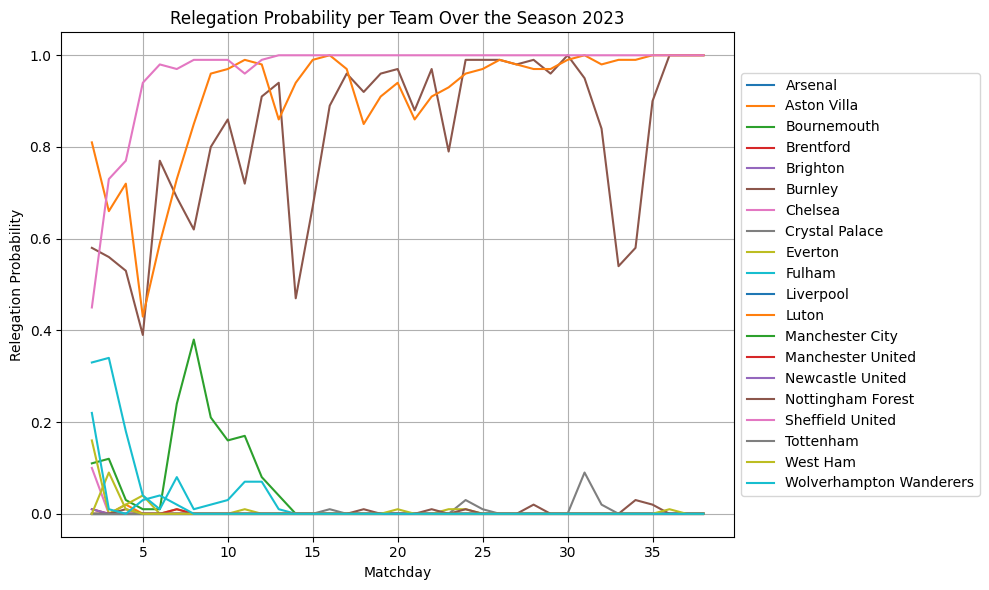

In [8]:
plt.figure(figsize=(10, 6))

for team in relegation_probs["name"].unique():
    team_data = relegation_probs[relegation_probs["name"] == team]
    plt.plot(team_data["matchday"], team_data["relegation_proba"], label=team)

plt.xlabel("Matchday")
plt.ylabel("Relegation Probability")
season = data.prem_data_collection.prem_season
plt.title(f"Relegation Probability per Team Over the Season {(season)}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# from RandomForest
importances = model.feature_importances_

# match them to column names
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(feature_importance_df)

                         Feature  Importance
15              avg_player_value    0.314562
6                non-penalty xGD    0.195666
11               attack_strength    0.153865
14               non-penality GD    0.129419
10               points_per_game    0.078473
9         goal_difference_so_far    0.039824
8   defending pressing intensity    0.016480
7             pressing intensity    0.015555
12                 defense_solid    0.011953
2                     Foreigners    0.010298
13              tactical_balance    0.009012
1                        avg_age    0.008110
5                    cumsum_xpts    0.007892
0                     squad_size    0.004590
3                       matchday    0.003029
4                     cumsum_pts    0.001272
